# HERMES calculation in the region: $l = [77^\circ, \, 88^\circ], \; b = [-1^\circ, \, 4^\circ]$

### <center> time of the calculation: $\mathrm{nside}=1024 \; \rightarrow \; t \sim 5 \, \mathrm{min}$

In [1]:
from pyhermes import *
from pyhermes.units import *
import astropy.units as u
import astropy.io.fits as pyfits
import numpy as np
import healpy
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as tick
import matplotlib.colors as colors
from matplotlib import cm
import time

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [3]:
nside = 1024
sun_pos = Vector3QLength(8.0*kpc, 0*pc, 0*pc)
conv_joule_GeV = 6.242e+9

In [4]:
## Block to dissect the DRAGON run ##


filename = '/home/ottavio/DRAGON2_dev/output/BaseModel_DRAGONxsec.fits.gz'


# Hadron section
dragon2D_proton = cosmicrays.Dragon2D(filename, [Proton])
dragon2D_helium = cosmicrays.Dragon2D(filename, [Helium])
cr_list = [dragon2D_proton, dragon2D_helium]

kamae_crosssection = interactions.Kamae06Gamma()
brems_crosssection = interactions.BremsstrahlungTsai74()

neutral_gas_HI = neutralgas.RingModel(neutralgas.GasType.HI)
neutral_gas_H2 = neutralgas.RingModel(neutralgas.GasType.H2)

In [5]:
## Block to define the integrators ##


# Hadron section
integratorHI = PiZeroIntegrator(cr_list, neutral_gas_HI, kamae_crosssection)
integratorH2 = PiZeroIntegrator(cr_list, neutral_gas_H2, kamae_crosssection)

integratorHI.setupCacheTable(120, 120, 24) # nx,ny,nz
integratorHI.setObsPosition(sun_pos)
integratorH2.setupCacheTable(120, 120, 24)
integratorH2.setObsPosition(sun_pos)
integratorH2.setupCacheTable(120, 120, 24)

In [6]:
## Block to build the Skymap containers ##


# Cygnus-X region coordinates
mask_edges = ([-1*deg, 4*deg], [77*deg, 82*deg])
mask = RectangularWindow(*mask_edges)

En_points = 12


# Hadron section
print("building SkyMapRange object for pi0")
skymapHI_range = GammaSkymapRange(nside, 10.*GeV, 10.*TeV, En_points)
skymapH2_range = GammaSkymapRange(nside, 10.*GeV, 10.*TeV, En_points)

skymapHI_range.setMask(mask)
skymapH2_range.setMask(mask)

building SkyMapRange object for pi0


In [7]:
SkyMapsOutputsFolder = '/home/ottavio/.virtualenvs/Hermes_Output/'

In [8]:
## Block to calculate the Skymaps ##


start = time.perf_counter()


print("Starting calculation of skymaps... ")
print('')


# Hadron section

# Calculation of HI skymap
skymapHI_range.setIntegrator(integratorHI)
skymapHI_range.compute()
nameHI = SkyMapsOutputsFolder + 'BaseRunHI_Cyg_nside' + str(nside)
skymapHI_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameHI)))
print("pi0 HI done")
print('')

# Calculation of H2 skymap
skymapH2_range.setIntegrator(integratorH2)
skymapH2_range.compute()
nameH2 = SkyMapsOutputsFolder + 'BaseRunH2_Cyg_nside' + str(nside)
skymapH2_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameH2)))
print("pi0 H2 done")
print('')



print('Total time:', time.perf_counter() - start, "seconds")

Starting calculation of skymaps... 

pi0 HI done

pi0 H2 done

Total time: 252.27744341300013 seconds


In [9]:
# Path to the HERMES output #

SkyMapsFolder = SkyMapsOutputsFolder + 'Sky_Maps/'

In [10]:
# Assignments to visualize the maps at a given energy #


reference_energy = 10.*GeV      # the energy is expressed in SI units, here [Joule]


energy_vector = np.asarray([s.getEnergy() for s in skymapHI_range])
index = np.argmin(np.abs(energy_vector - reference_energy))

print("We are going to visualize the maps at E =", energy_vector[index]/GeV, 'GeV')

We are going to visualize the maps at E = 10.0 GeV


n_ext_HI: 13 ; must be equal to len(E)+1 = 13

First HDU Header: SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2021-06-26T09:55:34' / file creation date (YYYY-MM-DDThh:mm:ss UT)   SOFTWARE= 'HERMES  '           / Created by Hermes, cosmicrays.github.io/hermes VERSION = 'v1.0.0-2-gb75233c2' / Hermes ver. [GIT_DESC]                         END                                                                                                                                                                                                                    

/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


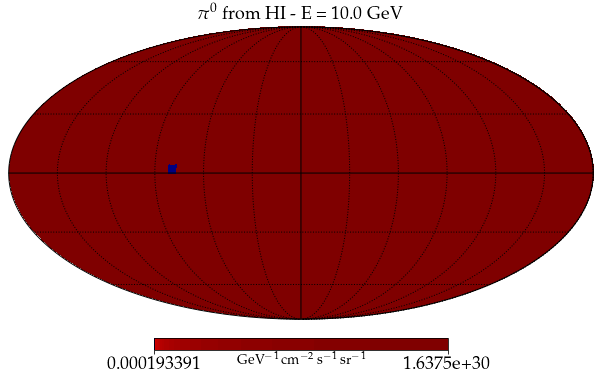

In [11]:
## Plot the atomic hydrogen (HI) mollview map ##


HI_hdulist = pyfits.open(SkyMapsOutputsFolder + 'BaseRunHI_Cyg_nside' + str(nside) + '.fits.gz')

n_ext_HI = len(HI_hdulist)
print('n_ext_HI:', n_ext_HI, '; must be equal to len(E)+1 =', En_points + 1)
print('')

first_hdu_HI = HI_hdulist[0]
first_hdu_header_HI = first_hdu_HI.header

print('First HDU Header:', first_hdu_header_HI)
print('')
print('index + 1:', index+1)
print('')

current_hdu = HI_hdulist[index+1]
current_header = current_hdu.header
print('current_header:', current_header)
print('')

nside = current_header['NSIDE']
npix = healpy.nside2npix(nside)

print('nside:', nside)
print('npix:', npix)
print('')

HI_map = np.zeros(npix)
HI_map_data = np.array(current_hdu.data)
HI_map[:] = HI_map_data[:]
print('HI_map.shape:', HI_map.shape)


# Plotting section
plt.rcParams.update({'font.size': 15})
healpy.mollview(abs(HI_map), coord = "G", title=r"$\pi^0$ from HI - E = " + str(reference_energy/GeV) + ' GeV', unit = '$\mathrm{GeV^{-1} \, cm^{-2} \, s^{-1} \, sr^{-1}}$',
                     norm = 'log', xsize = 3600, notext = 'True', cbar = True, cmap='jet')
healpy.graticule()



plt.savefig(SkyMapsFolder + 'pi0_mollview_Cygnus_HI_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)

n_ext_H2: 13 ; must be equal to len(E)+1 = 13

First HDU Header: SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2021-06-26T09:57:40' / file creation date (YYYY-MM-DDThh:mm:ss UT)   SOFTWARE= 'HERMES  '           / Created by Hermes, cosmicrays.github.io/hermes VERSION = 'v1.0.0-2-gb75233c2' / Hermes ver. [GIT_DESC]                         END                                                                                                                                                                                                                    

/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/ottavio/.virtualenvs/hermes/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a g

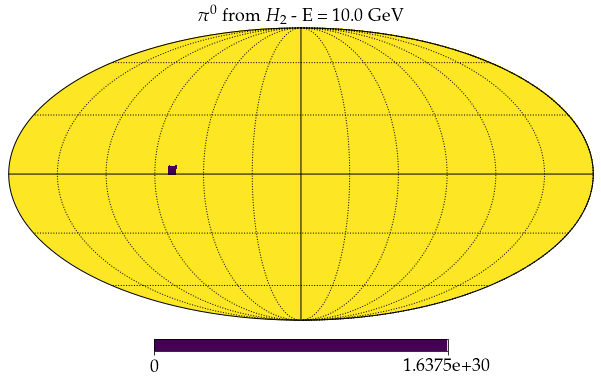

In [12]:
## Plot the molecular hydrogen (H2) mollview map ##


H2_hdulist = pyfits.open(SkyMapsOutputsFolder + 'BaseRunH2_Cyg_nside' + str(nside) + '.fits.gz')


n_ext_H2 = len(H2_hdulist)
print('n_ext_H2:', n_ext_H2, '; must be equal to len(E)+1 =', En_points + 1)
print('')

first_hdu_H2 = H2_hdulist[0]
first_hdu_header_H2 = first_hdu_H2.header

print('First HDU Header:', first_hdu_header_H2)
print('')
print('index + 1:', index+1)
print('')

current_hdu = H2_hdulist[index+1]
current_header = current_hdu.header
print('current_header:', current_header)
print('')

nside = current_header['NSIDE']
npix = healpy.nside2npix(nside)

print('nside:', nside)
print('npix:', npix)
print('')

H2_map = np.zeros(npix)
H2_map_data = np.array(current_hdu.data)
H2_map[:] = H2_map_data[:]
print('H2_map.shape:', H2_map.shape)


# Plotting section
plt.rcParams.update({'font.size': 15})
healpy.mollview(abs(H2_map), coord = "G", title=r"$\pi^0$ from $H_2$ - E = " + str(reference_energy/GeV) + ' GeV', unit = '',
                     norm = 'hist', xsize = 3600, notext = 'True', cbar = True) #, cmap='jet')
healpy.graticule()



plt.savefig(SkyMapsFolder + 'pi0_mollview_Cygnus_H2_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)

12582912
3547
3547
1.0
1.0


<ipython-input-13-60cb8d55de5f>:50: RuntimeWarning: invalid value encountered in log10
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
<ipython-input-13-60cb8d55de5f>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)


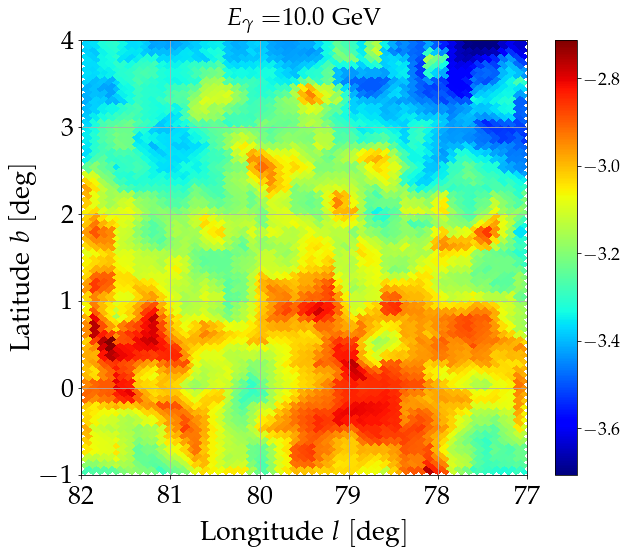

In [13]:
## Cartesian map at given reference energy ##


fig = plt.figure(figsize=[10,8])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7


cmap = "jet"


# Cygnus-X region coordinates #
b_min = -1.
b_max = 4.
l_min = 77.
l_max = 82.


# theta = [0, 180], where 0 is the galactic north-pole
theta_min = np.pi/2. - np.radians(b_min)
theta_max = np.pi/2. - np.radians(b_max)
phi_min = np.radians(l_min)
phi_max = np.radians(l_max)


numpix = healpy.nside2npix(nside)
xsize = int(np.sqrt((l_max-l_min)/(b_max-b_min)*numpix))
ysize = int((b_max-b_min)/(l_max-l_min)*xsize)
print(numpix)
print(xsize)
print(ysize)
print((b_max-b_min)/(l_max-l_min))
print((l_max-l_min)/(b_max-b_min))


b = np.linspace(b_min, b_max, ysize)
l = np.linspace(l_min, l_max, xsize)
theta = np.linspace(theta_min, theta_max, ysize)
phi   = np.linspace(phi_min, phi_max, xsize)

PHI, THETA = np.meshgrid(phi, theta)
grid_pix = healpy.ang2pix(nside, THETA, PHI)
grid_map = H2_map[grid_pix] + HI_map[grid_pix]


image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
cbar = plt.colorbar(image)

plt.grid(True)
plt.title('$E_{\gamma} =$' + str(reference_energy/GeV) + ' GeV', fontsize=25, pad=15)


# Plot the longitudinal axis inverted
ax.set_xlim(l_max, l_min)
ax.set_xlabel(r'${\rm Longitude} \; l \; {\rm [deg]}$', fontsize=27, color='k')
ax.set_ylabel(r'${\rm Latitude} \; b \; {\rm [deg]}$', fontsize=27, color='k')


plt.savefig(SkyMapsFolder + 'pi0_cartesian_Cygnus_nside=' + str(nside) + '_E=' + str(reference_energy/GeV) + 'GeV.pdf', dpi=300)  

n_ext_HI: 13 ; must be equal to len(E)+1 = 13
n_ext_H2: 13 ; must be equal to len(E)+1 = 13

nside =  1024

npix: 12582912
xsize: 3547
ysize: 3547

Delta b / Delta l: 1.0
Delta l / Delta b: 1.0

current energy: 10.000785631854 GeV

current energy: 18.739646359259797 GeV

current energy: 35.114675846223236 GeV

current energy: 65.7984913987475 GeV

current energy: 123.29435958090242 GeV

current energy: 231.0311191231085 GeV

current energy: 432.91013623581404 GeV

current energy: 811.1945558115287 GeV

current energy: 1520.030492009137 GeV

current energy: 2848.2596192057613 GeV

current energy: 5337.118499297438 GeV

current energy: 10000.785631854 GeV



<ipython-input-14-3fd6d95810fd>:99: RuntimeWarning: invalid value encountered in log10
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
<ipython-input-14-3fd6d95810fd>:99: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)


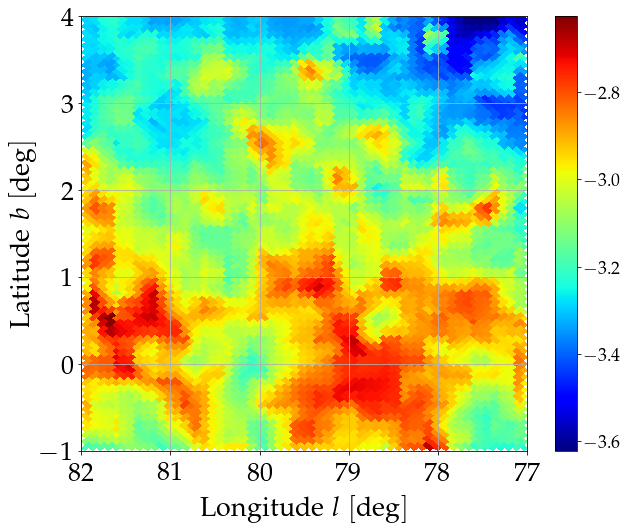

In [14]:
## Block to compute the integrated gamma-ray emission above a certain energy ##


n_ext_HI = len(HI_hdulist)
n_ext_H2 = len(H2_hdulist)
print('n_ext_HI:', n_ext_HI, '; must be equal to len(E)+1 =', En_points + 1)
print('n_ext_H2:', n_ext_H2, '; must be equal to len(E)+1 =', En_points + 1)
print('')
print('nside = ', nside)
print('')


npix = healpy.nside2npix(nside)


# Cygnus-X region coordinates
b_min = -1.
b_max = 4.
l_min = 77.
l_max = 82.


# theta = [0, 180], where 0 is the galactic north-pole
theta_min = np.pi/2. - np.radians(b_min)
theta_max = np.pi/2. - np.radians(b_max)
phi_min = np.radians(l_min)
phi_max = np.radians(l_max)


xsize = int(np.sqrt((l_max-l_min)/(b_max-b_min)*npix))
ysize = int((b_max-b_min)/(l_max-l_min)*xsize)
print('npix:', npix)
print('xsize:', xsize)
print('ysize:', ysize)
print('')
print('Delta b / Delta l:', (b_max-b_min)/(l_max-l_min))
print('Delta l / Delta b:', (l_max-l_min)/(b_max-b_min))
print('')

b = np.linspace(b_min, b_max, ysize)
l = np.linspace(l_min, l_max, xsize)
theta = np.linspace(theta_min, theta_max, ysize)
phi   = np.linspace(phi_min, phi_max, xsize)

PHI, THETA = np.meshgrid(phi, theta)
grid_pix = healpy.ang2pix(nside, THETA, PHI)



# Loop over the energy to sum the fluxes
HI_map_array = np.zeros( (En_points, npix) )
HI_map_tot = np.zeros(npix)
H2_map_array = np.zeros( (En_points, npix) )
H2_map_tot = np.zeros(npix)


for ie in range(En_points):
    
    # HI section
    current_hdu_HI = HI_hdulist[ie+1]
    current_header_HI = current_hdu_HI.header
    current_energy_HI = current_header_HI['ENERGY']
    print('current energy:', current_energy_HI*conv_joule_GeV, 'GeV')
    print('')
    
    HI_map_data = np.array(current_hdu_HI.data)
    HI_map_array[ie, :] = HI_map_data[:]
    
    HI_map_tot[grid_pix] = HI_map_tot[grid_pix] + HI_map_array[ie, grid_pix]
    
    
    # H2 section
    current_hdu_H2 = H2_hdulist[ie+1]
    current_header_H2 = current_hdu_H2.header
    current_energy_H2 = current_header_H2['ENERGY']
    
    H2_map_data = np.array(current_hdu_H2.data)
    H2_map_array[ie, :] = H2_map_data[:]
    
    H2_map_tot[grid_pix] = H2_map_tot[grid_pix] + H2_map_array[ie, grid_pix]
    


fig = plt.figure(figsize=[10,8])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7


cmap = "jet"


grid_map = H2_map_tot[grid_pix] + HI_map_tot[grid_pix]


image = plt.pcolormesh(l, b, np.log10(grid_map), rasterized=True, cmap=cmap)
cbar = plt.colorbar(image)

plt.grid(True)
# Plot the longitudinal axis inverted
ax.set_xlim(l_max, l_min)
ax.set_xlabel(r'${\rm Longitude} \; l \; {\rm [deg]}$', fontsize=27, color='k')
ax.set_ylabel(r'${\rm Latitude} \; b \; {\rm [deg]}$', fontsize=27, color='k')


plt.savefig(SkyMapsFolder + 'pi0_cartesian_Cygnus_nside=' + str(nside) + '_Integrated.pdf', dpi=300)  

GeV unit: 1.6021766339999998e-10 Joule (SI)

len(theta), len(phi): 12582912 12582912
theta: [7.97359963e-04 7.97359963e-04 7.97359963e-04 ... 3.14079529e+00
 3.14079529e+00 3.14079529e+00]
phi: [0.78539816 2.35619449 3.92699082 ... 2.35619449 3.92699082 5.49778714]

len(b): 12582912
b: [ 1.56999897  1.56999897  1.56999897 ... -1.56999897 -1.56999897
 -1.56999897]

low b in the Southern emisphere: -0.017453292519943295 , high b in the Northern emisphere: 0.06981317007977318

len(mask): 12582912 , npix: 12582912
Number of 1`s in the mask: 7571



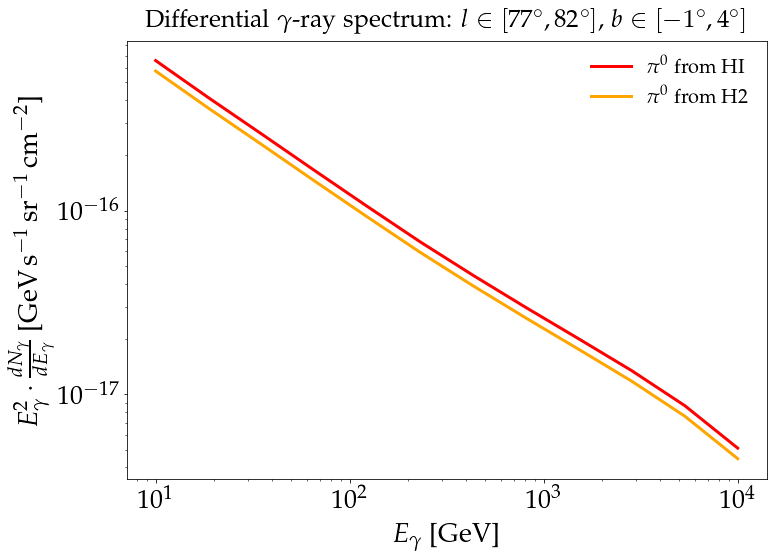

In [15]:
### Block to compute the gamma-ray spectrum ###


use_units = "GeV^-1 cm^-2 s^-1"                    # edit here to change the units 
skymap_units = u.Quantity(1, use_units)
base_units = skymap_units.unit.si.scale

use_units_diff = "GeV^-1 cm^-2 s^-1 sr^-1"         # edit here to change the units
skymap_units_diff = u.Quantity(1, use_units_diff)
base_units_diff = skymap_units_diff.unit.si.scale


use_unit = "GeV"                                   # edit here to change the units
myGeV = u.Quantity(1, use_unit)
GeV_unit = float(myGeV.unit.si.scale)
spectral_units = float(base_units)
spectral_units_diff = float(base_units_diff)
print('GeV unit:', GeV_unit, 'Joule (SI)')
print('')



def rectangular_mask_symmetric(nside,lowb_North,highb_North,lowb_South,highb_South,lowl,highl):
    
    # convert degrees to radians
    lowb_North = lowb_North/180.*np.pi
    lowb_South = lowb_South/180.*np.pi
    lowl= lowl/180.*np.pi
    highb_North = highb_North/180.*np.pi
    highb_South = highb_South/180.*np.pi
    highl= highl/180.*np.pi
    
    npix=12*nside**2
    listpix = np.arange(npix)
    theta, phi = healpy.pixelfunc.pix2ang(nside, listpix, nest=False, lonlat=False)
    
    print('len(theta), len(phi):', len(theta), len(phi))
    print('theta:', theta)
    print('phi:', phi)
    print('')
    
    b = np.pi/2. - theta
    l = phi
    
    print('len(b):', len(b))
    print('b:', b)
    print('')
    print('low b in the Southern emisphere:', lowb_South, ', high b in the Northern emisphere:', highb_North)
    print('')
    
    mask = []
    count_mask1 = 0
    for i in np.arange(npix):
        
        if ( (b[i] >= lowb_North and b[i] <= highb_North) or\
             (b[i] >= lowb_South and b[i] <= highb_South) or\
             (b[i] >= lowb_South and b[i] <= highb_North) ) and\
             (l[i] >= lowl and l[i] <= highl) :
            count_mask1 = count_mask1 + 1
            mask.append(1)
        
        else:
            mask.append(0)
            
    print('len(mask):', len(mask), ', npix:', npix)
    print('Number of 1`s in the mask:', count_mask1)
    print('')
    
    return mask



# select a mask
newMask = rectangular_mask_symmetric(nside, 0., 4., -1., 0., 77., 82.)



# Section to compute the differential spectrum #
def calc_mean_flux_diff(hdulist, nside, mask):
    energies = np.asarray([float(hdulist[index+1].header['ENERGY'])/GeV_unit for index in range(n_ext_H2-1)])
    fluxesMatrix = np.zeros(( healpy.nside2npix(nside), n_ext_H2-1))
    
    for index in range(n_ext_H2-1):
        fluxesMatrix[:,index] = np.asarray([hdulist[index+1].data])
    
    # Differential spectrum: averaged, per solid angle #
    fluxes_diff = np.asarray( [ np.sum(fluxesMatrix[:,index]*mask[:])/np.sum(mask[:]) for index in range(n_ext_H2-1) ] )
    
    return energies, fluxes_diff


def plot_diff_spectrum(hdulist, label, nside, mask, color):
    energies, fluxes_diff = calc_mean_flux_diff(hdulist, nside, mask)
    plt.plot(energies, fluxes_diff*(energies)**2/spectral_units_diff, '-', lw='3.', label=label, color=color)



# Plotting
fig = plt.figure(figsize=[11,8])
fig.set_tight_layout(True)


plot_diff_spectrum(HI_hdulist, r'$\pi^0$ from HI', nside, newMask, "red")
plot_diff_spectrum(H2_hdulist, r'$\pi^0$ from H2', nside, newMask, "orange")

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7


plt.legend(frameon=False, fontsize = 20)
plt.title("Differential $\\gamma$-ray spectrum: $l \in [77^\circ, 82^\circ]$, $b \in [-1^\circ, 4^\circ]$", fontsize=25, pad=15)
plt.xlabel("$E_\gamma$  [GeV]", fontsize=27)
plt.ylabel("$E_\gamma^2 \cdot \\frac{d N_\gamma}{d E_\gamma}$  [" + (skymap_units_diff*u.GeV**2).unit.to_string(format='latex_inline') + "]", fontsize=27)
plt.xscale("log")
plt.yscale("log")


plt.savefig(SkyMapsFolder + 'differential_spectrum_gamma_Cygnus_nside=' + str(nside) + '.pdf', dpi=150)     